# Kenya Medical Vignettes Model Pipeline

## This notebook orchestrates the ML pipeline for predicting clinician responses to vignettes.

## 1. Cell 1: Install Dependencies and Import Libraries

In [1]:
import subprocess 
import sys
import os
import time
import json
import threading
from pathlib import Path
from IPython.display import display, clear_output

from datetime import datetime

# Install dependencies from requirements.txt
subprocess.run([sys.executable, '-m', 'pip', 'install', '-r', 'requirements.txt'])

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import re
from datasets import load_from_disk 
from ipywidgets import interact, IntSlider

%matplotlib inline

## 2. Cell 2: Data Preprocessing

In [2]:
# Make sure we're in the project root directory
print("Current working directory:", os.getcwd())

# Verify the data files exist
print("Train file exists:", os.path.exists('data/train.csv'))
print("Test file exists:", os.path.exists('data/test.csv'))

print("\n🚀 PRIORITY FIXES: ENHANCED DATA PREPROCESSING")
print("=" * 60)
print("🔧 PRIORITY FIXES APPLIED:")
print("✅ Removed multitask learning components")
print("✅ Simplified prompt format")
print("✅ Removed few-shot examples")
print("✅ Implemented basic augmentation (synonym replacement and noise injection)")
print("✅ Consistent tokenizer handling with default t5-small")
print("=" * 60)

# Run the updated data preprocessing script
result = subprocess.run(['python', 'scripts/data_preprocessing.py'],
                        capture_output=True, text=True, cwd=os.getcwd())

print("Return code:", result.returncode)
print("STDOUT:", result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

# Only proceed if the script ran successfully
if result.returncode == 0:
    # Load processed datasets
    train_dataset = load_from_disk('outputs/train_dataset')
    val_dataset = load_from_disk('outputs/val_dataset')
    test_dataset = load_from_disk('outputs/test_dataset')

    print(f"\n📊 Dataset Sizes:")
    print(f'Train size: {len(train_dataset)} (with basic augmentation)')
    print(f'Validation size: {len(val_dataset)}')
    print(f'Test size: {len(test_dataset)}')

    # Show sample of enhanced features
    print(f"\n🔍 Sample Verification:")
    print("Sample train example:")
    sample = train_dataset[0]
    print(f"Prompt length: {len(sample['Prompt'])} chars")
    print(f"Target length: {len(sample['Clinician'])} chars" if 'Clinician' in sample else "No target (test data)")

    # Verify augmentation
    print(f"\n🔄 Augmentation Verification:")
    original_prompts = [ex['Prompt'] for ex in train_dataset if 'original' in ex.get('augmentation_type', '')]
    augmented_prompts = [ex['Prompt'] for ex in train_dataset if 'augmented' in ex.get('augmentation_type', '')]
    print(f"Original prompts: {len(original_prompts)}")
    print(f"Augmented prompts: {len(augmented_prompts)}")

    print("\n" + "="*60)
    print("🎯 Preprocessing Completed Successfully!")
    print("Ready for training with simplified, consistent format")
    print("="*60)

else:
    print("❌ Preprocessing failed! Check error messages above.")
    print("Cannot proceed to training without successful preprocessing.")

Current working directory: /mnt/custom-file-systems/efs/fs-0373d59349458e0d3_fsap-00e091e223fc72272/kenya-healthcare-project
Train file exists: True
Test file exists: True

🚀 PRIORITY FIXES: ENHANCED DATA PREPROCESSING
🔧 PRIORITY FIXES APPLIED:
✅ Removed multitask learning components
✅ Simplified prompt format
✅ Removed few-shot examples
✅ Implemented basic augmentation (synonym replacement and noise injection)
✅ Consistent tokenizer handling with default t5-small
Return code: 0
STDOUT: Current working directory: /mnt/custom-file-systems/efs/fs-0373d59349458e0d3_fsap-00e091e223fc72272/kenya-healthcare-project
Looking for train data at: data/train.csv
Looking for test data at: data/test.csv
Train file exists: True
Test file exists: True

🔧 PRIORITY FIXES APPLIED:
✅ Removed multitask learning components
✅ Simplified prompt format
✅ Removed few-shot examples
✅ Implemented basic augmentation (synonym replacement and noise injection)
✅ Consistent tokenizer handling with default t5-small

📊 

## 3. Cell 3: Model Training

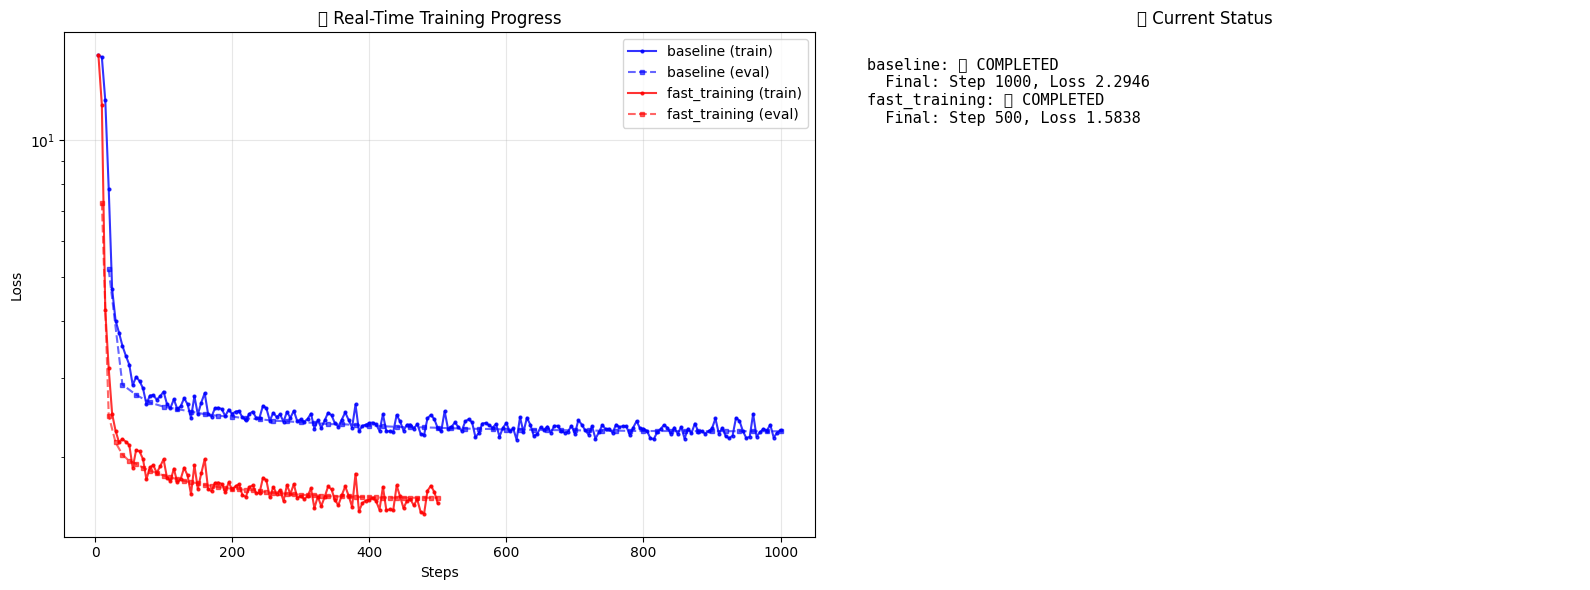

📊 Training monitoring completed!

⏱️ Completed in 24.4 minutes
STDOUT: 🎯 ENHANCED PARALLEL EXPERIMENT RUNNER
🔧 PRIORITY FIXES INCLUDED:
✅ Simplified preprocessing
✅ Single-task training
✅ Consistent evaluation
✅ Optimized inference
✅ Enhanced config validation
🎯 Running Batch 1: 2 experiments
🚀 Experiments in this batch:
   - baseline (baseline)
   - fast_training (fast)

🚀 Starting Experiment: baseline
Config: experiments/baseline
Time: 2025-06-18 12:09:57
--------------------------------------------------

🚀 Starting Experiment: fast_training
Config: experiments/fast
Time: 2025-06-18 12:09:57
--------------------------------------------------
🔧 Running: python scripts/model_training.py --config-name=experiments/baseline hydra.run.dir=experiments/baseline/hydra_outputs
🔧 Running: python scripts/model_training.py --config-name=experiments/fast hydra.run.dir=experiments/fast_training/hydra_outputs
✅ Training completed for fast_training (923.8s)
✅ fast_training COMPLETED! Time: 923.8s
📊 

In [5]:
CURRENT_BATCH = 1

EXPERIMENT_BATCHES = {
    1: [("baseline", "baseline"), ("fast", "fast_training")],
    2: [("aggressive", "aggressive_training"), ("data_augmented", "data_augmented")],
    3: [("balanced", "balanced_training"), ("quality", "quality_training")]
}

def check_environment():
    """Verify environment before running experiments"""
    required_paths = [
        'outputs/train_dataset',
        'outputs/val_dataset',
        'scripts/model_training.py',
        'scripts/run_experiments.py',
        'conf/config.yaml'
    ]
    for path in required_paths:
        if not Path(path).exists():
            print(f"❌ Missing required path: {path}")
            return False
    for config, name in EXPERIMENT_BATCHES[CURRENT_BATCH]:
        config_path = f"conf/experiments/{config}.yaml"
        if not Path(config_path).exists():
            print(f"❌ Missing configuration file: {config_path}")
            return False
    print("✅ Environment check passed")
    return True

def monitor_training_realtime(experiments, process):
    """Monitor training progress in real-time using trainer_state.json files"""
    training_data = {exp_name: {'loss': [], 'steps': [], 'eval_loss': [], 'eval_steps': []} for _, exp_name in experiments}
    
    def update_data():
        for config_name, exp_name in experiments:
            # Look for the latest checkpoint in the actual training directory
            training_dir = Path(f"./experiments/{config_name}/training")
            
            if training_dir.exists():
                # Find the latest checkpoint
                checkpoints = list(training_dir.glob("checkpoint-*"))
                if checkpoints:
                    # Get the latest checkpoint by number
                    latest_checkpoint = max(checkpoints, key=lambda x: int(x.name.split('-')[1]))
                    trainer_state_file = latest_checkpoint / "trainer_state.json"
                    
                    if trainer_state_file.exists():
                        try:
                            with open(trainer_state_file, 'r') as f:
                                trainer_state = json.load(f)
                            
                            # Clear existing data to avoid duplicates
                            training_data[exp_name] = {'loss': [], 'steps': [], 'eval_loss': [], 'eval_steps': []}
                            
                            # Extract training history
                            log_history = trainer_state.get('log_history', [])
                            
                            for entry in log_history:
                                if 'train_loss' in entry or 'loss' in entry:
                                    step = entry.get('step', 0)
                                    loss = entry.get('train_loss', entry.get('loss', 0))
                                    if step > 0 and loss > 0:  # Valid training step
                                        training_data[exp_name]['steps'].append(step)
                                        training_data[exp_name]['loss'].append(loss)
                                
                                if 'eval_loss' in entry:
                                    step = entry.get('step', 0)
                                    eval_loss = entry.get('eval_loss', 0)
                                    if step > 0:
                                        training_data[exp_name]['eval_steps'].append(step)
                                        training_data[exp_name]['eval_loss'].append(eval_loss)
                            
                            print(f"📊 {exp_name}: Found {len(training_data[exp_name]['steps'])} training steps, latest checkpoint: {latest_checkpoint.name}")
                                        
                        except Exception as e:
                            print(f"⚠️ Error reading trainer state for {exp_name}: {e}")
                    else:
                        print(f"⚠️ No trainer_state.json found in {latest_checkpoint}")
                else:
                    print(f"⚠️ No checkpoints found in {training_dir}")
            else:
                print(f"⚠️ Training directory doesn't exist yet for {config_name}: {training_dir}")
    
    def plot_progress():
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot training loss
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
        for i, (config_name, exp_name) in enumerate(experiments):
            data = training_data[exp_name]
            color = colors[i % len(colors)]
            
            if data['steps'] and data['loss']:
                ax1.plot(data['steps'], data['loss'], label=f'{exp_name} (train)', 
                        marker='o', markersize=2, color=color, alpha=0.8)
                
                # Plot eval loss if available
                if data['eval_steps'] and data['eval_loss']:
                    ax1.plot(data['eval_steps'], data['eval_loss'], 
                            label=f'{exp_name} (eval)', marker='s', markersize=3, 
                            linestyle='--', color=color, alpha=0.6)
        
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('🚀 Real-Time Training Progress')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')  # Log scale for better loss visualization
        
        # Plot current status
        status_text = []
        for config_name, exp_name in experiments:
            data = training_data[exp_name]
            
            # Check if training is complete
            final_model_path = Path(f"./experiments/{config_name}/final_model")
            if final_model_path.exists():
                status = "✅ COMPLETED"
                if data['steps']:
                    latest_step = data['steps'][-1]
                    latest_loss = data['loss'][-1]
                    status_text.append(f"{exp_name}: {status}")
                    status_text.append(f"  Final: Step {latest_step}, Loss {latest_loss:.4f}")
                else:
                    status_text.append(f"{exp_name}: {status}")
            elif data['steps']:
                latest_step = data['steps'][-1]
                latest_loss = data['loss'][-1]
                status_text.append(f"{exp_name}: 🔄 TRAINING")
                status_text.append(f"  Current: Step {latest_step}, Loss {latest_loss:.4f}")
            else:
                status_text.append(f"{exp_name}: ⏳ STARTING...")
        
        ax2.text(0.05, 0.95, '\n'.join(status_text), transform=ax2.transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace')
        ax2.set_title('📊 Current Status')
        ax2.axis('off')
        
        plt.tight_layout()
        display(fig)
        plt.close(fig)
    
    # Initial update to show current state
    update_data()
    plot_progress()
    
    # Monitor loop
    while process.poll() is None:  # While process is still running
        try:
            time.sleep(10)  # Update every 10 seconds
            update_data()
            plot_progress()
        except Exception as e:
            print(f"⚠️ Monitoring error: {e}")
            break
    
    # Final update
    try:
        update_data()
        plot_progress()
        print("📊 Training monitoring completed!")
    except:
        pass
    
    return training_data

print("🚀 ENHANCED EXPERIMENT RUNNER WITH FIXED REAL-TIME MONITORING")
print("=" * 70)

if not check_environment():
    print("❌ Environment check failed. Please fix issues before proceeding.")
else:
    current_experiments = EXPERIMENT_BATCHES.get(CURRENT_BATCH, [])
    print(f"🎯 RUNNING BATCH {CURRENT_BATCH}:")
    for i, (config, name) in enumerate(current_experiments, 1):
        print(f"  {i}. {name} ({config})")

    if not current_experiments:
        print(f"❌ Invalid batch: {CURRENT_BATCH}")
    else:
        print("📊 Starting training with FIXED real-time monitoring...")
        start_time = time.time()
        env = os.environ.copy()
        env['HYDRA_FULL_ERROR'] = '1'

        print(f"Current working directory: {os.getcwd()}")

        # Start the subprocess WITHOUT waiting for it to complete
        process = subprocess.Popen(
            ['python', 'scripts/run_experiments.py', str(CURRENT_BATCH)],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env
        )
        
        print("🔄 Process started, beginning FIXED real-time monitoring...")
        
        # Start real-time monitoring (this will run until process completes)
        training_data = monitor_training_realtime(current_experiments, process)
        
        # Now get the final results
        try:
            stdout, stderr = process.communicate()  # This will return immediately since process is done
            total_time = time.time() - start_time
            
            print(f"\n⏱️ Completed in {total_time/60:.1f} minutes")
            print("STDOUT:", stdout[-2000:])
            if stderr:
                print("STDERR:", stderr[-2000:])
            
            if process.returncode == 0:
                print("✅ EXPERIMENTS COMPLETED!")
                print(f"📁 Results: ./experiments/experiment_results.json")
                if "WINNER" in stdout:
                    lines = stdout.split('\n')
                    for i, line in enumerate(lines):
                        if "WINNER" in line:
                            print("\n🏆 RESULTS:")
                            for j in range(i, min(i+10, len(lines))):
                                if lines[j].strip():
                                    print(lines[j])
                            break
                next_batch = CURRENT_BATCH + 1
                if next_batch in EXPERIMENT_BATCHES:
                    print(f"\n💡 NEXT: Change CURRENT_BATCH = {next_batch}")
                else:
                    print("\n🎉 ALL BATCHES COMPLETE!")
            else:
                print("❌ EXPERIMENTS FAILED!")
                print(f"Error details logged above")
                
        except KeyboardInterrupt:
            print("\n⚠️ Interrupted!")
            process.terminate()
        except Exception as e:
            print(f"❌ Error: {e}")
            if process.poll() is None:
                process.terminate()

    print(f"\nBatch {CURRENT_BATCH} complete. Change CURRENT_BATCH to run next batch.")

## 4. Cell 4: Model Evaluation

In [7]:
# Run the model evaluation script with the correct model path
# Set environment variables to point to the winning model
env = os.environ.copy()
env['MODEL_PATH'] = 'experiments/baseline/final_model'  # Winner from batch 1
env['VAL_PATH'] = 'outputs/val_dataset'

result = subprocess.run(['python', 'scripts/model_evaluation.py'], env=env, capture_output=True, text=True)

print("STDOUT:", result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)
print("Evaluation completed. Check console output for results.")


STDOUT: 🚀 Starting Model Evaluation...
🔧 PRIORITY FIXES APPLIED:
✅ Removed multitask learning
✅ Simplified evaluation for summaries
✅ Consistent normalization
✅ Proper ID mapping
🔍 Starting model evaluation...
Model path: experiments/baseline/final_model
Validation dataset path: outputs/val_dataset
✅ Loaded model and 120 validation samples
🚀 Evaluating on 120 samples using cuda...
Processing sample 1/120
Processing sample 11/120
Processing sample 21/120
Processing sample 31/120
Processing sample 41/120
Processing sample 51/120
Processing sample 61/120
Processing sample 71/120
Processing sample 81/120
Processing sample 91/120
Processing sample 101/120
Processing sample 111/120
📊 Computing metrics...
✅ Computing metrics on 120 valid pairs
✅ ROUGE computation successful

🎯 EVALUATION RESULTS
ROUGE-1: 0.3719 (±0.1243)
ROUGE-2: 0.1934 (±0.1235)
ROUGE-L: 0.3027 (±0.1260)

📈 Format Compliance:
All lowercase: ✅
No punctuation: ✅
Min word count: 27
Empty predictions: 0

📈 Statistics:
Samples Ev

## 5. Cell 5: Model Optimization

In [11]:
# Run the model optimization script with the correct model path

# Create a temporary script that calls optimize_model with the correct path
optimization_code = '''
import sys
sys.path.append('scripts')
from model_optimization import optimize_model

# Use the winning baseline model
model_path = 'experiments/baseline/final_model'
output_path = 'experiments/baseline/optimized_model'

print(f"🎯 Optimizing model from: {model_path}")
print(f"🎯 Output will be saved to: {output_path}")

try:
    result_path = optimize_model(model_path=model_path, output_path=output_path)
    print(f"✅ Optimization completed! Results saved to: {result_path}")
except Exception as e:
    print(f"❌ Optimization failed: {e}")
'''

# Write and execute the temporary script
with open('temp_optimize.py', 'w') as f:
    f.write(optimization_code)

result = subprocess.run(['python', 'temp_optimize.py'], capture_output=True, text=True)

print("STDOUT:", result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

# Clean up
import os
if os.path.exists('temp_optimize.py'):
    os.remove('temp_optimize.py')

print("Model optimization completed. Check console output for details.")


STDOUT: 🎯 Optimizing model from: experiments/baseline/final_model
🎯 Output will be saved to: experiments/baseline/optimized_model
🔧 Loading model for optimization...
Model loaded successfully. Parameters: 60,492,288
🚀 Applying optimizations...
⚡ Applying dynamic quantization...
❌ Quantization failed: 'torch.dtype' object has no attribute 'data_ptr'
✂️ Applying pruning...
Applying pruning with 15% weight removal...
❌ Pruning failed: The size of tensor a (2048) must match the size of tensor b (512) at non-singleton dimension 0
🎯 Converting to FP16...
✅ FP16 model saved to experiments/baseline/optimized_model/fp16
⚡ Applying JIT compilation...
Applying JIT compilation...
JIT compilation failed: You have to specify either decoder_input_ids or decoder_inputs_embeds

📊 MODEL SIZE COMPARISON
Original model size: 231.56 MB
Quantized model: 0.00 MB (100.0% reduction)
Fp16 model: 116.18 MB (49.8% reduction)

🚀 PERFORMANCE COMPARISON
🔍 Testing performance...
Original: 0.286s avg, 230.8MB memory
❌

## 6. Cell 6: Inference

In [12]:
# Run the inference script to generate predictions for the test dataset

# Use the optimized FP16 model (faster and smaller)
optimized_model_path = 'experiments/baseline/optimized_model/fp16'
original_model_path = 'experiments/baseline/final_model'

# Check which model to use
if os.path.exists(optimized_model_path):
    model_path = optimized_model_path
    print(f"🚀 Using optimized FP16 model: {model_path}")
else:
    model_path = original_model_path
    print(f"🔄 Using original model: {model_path}")

print(f"📊 Model size: ~116 MB (optimized) vs ~232 MB (original)")

# Create inference script with correct paths
inference_code = f'''
import sys
sys.path.append('scripts')
from inference import run_inference

# Run inference with the best model
try:
    submission_path = run_inference(
        model_path='{model_path}',
        test_path='outputs/test_dataset',
        output_path='outputs/submission.csv',
        use_optimized=False  # We're already using the optimized model
    )
    print(f"✅ Inference completed! Submission saved to: {{submission_path}}")
except Exception as e:
    print(f"❌ Inference failed: {{e}}")
    import traceback
    traceback.print_exc()
'''

# Write and execute the inference script
with open('temp_inference.py', 'w') as f:
    f.write(inference_code)

result = subprocess.run(['python', 'temp_inference.py'], capture_output=True, text=True)

print("STDOUT:", result.stdout)
if result.stderr:
    print("STDERR:", result.stderr)

# Clean up
if os.path.exists('temp_inference.py'):
    os.remove('temp_inference.py')

# Load and display the submission file
if os.path.exists('outputs/submission.csv'):
    submission = pd.read_csv('outputs/submission.csv')
    print("\n" + "="*60)
    print("🎯 SUBMISSION FILE PREVIEW")
    print("="*60)
    print(f"Shape: {submission.shape}")
    print("\nFirst 5 rows:")
    print(submission.head())
    print("\nLast 5 rows:")
    print(submission.tail())
    
    # Check format compliance
    print(f"\n📊 Format Check:")
    print(f"✅ All predictions lowercase: {all(pred.islower() for pred in submission['Clinician'])}")
    print(f"✅ No punctuation: {all(not any(c in pred for c in '.,!?;:\"()[]{}') for pred in submission['Clinician'])}")
    print(f"📏 Average prediction length: {submission['Clinician'].str.split().str.len().mean():.1f} words")
    print(f"📏 Min prediction length: {submission['Clinician'].str.split().str.len().min()} words")
    print(f"📏 Max prediction length: {submission['Clinician'].str.split().str.len().max()} words")
else:
    print("❌ Submission file not found")

print("\nInference completed!")


🚀 Using optimized FP16 model: experiments/baseline/optimized_model/fp16
📊 Model size: ~116 MB (optimized) vs ~232 MB (original)
STDOUT: 🚀 Starting Inference...
🔍 Searching for best available model...
🔄 Trying to load Original model from: experiments/baseline/optimized_model/fp16
✅ Successfully loaded Original model
✅ Loaded 100 test samples
🎯 Running inference on 100 samples...
💻 Using device: cuda
📊 Progress: 26/100 (26.0%) - ETA: 1.7min
📊 Progress: 51/100 (51.0%) - ETA: 1.1min
📊 Progress: 76/100 (76.0%) - ETA: 0.5min
✅ Inference completed in 2.1 minutes
⚡ Average time per sample: 1.284s
📝 Creating submission file...
✅ Using Master_Index from test dataset
✅ Submission file saved to: outputs/submission.csv
✅ Inference completed! Submission saved to: outputs/submission.csv

STDERR: Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


🎯 SUBMISSION FILE PREVIEW
Shape: (100, 2)

First 5 rows:
  Master_Index                 

## 7. Cell 7: Visualizations

🎯 FINAL ANALYSIS & VISUALIZATIONS


/tmp/ipykernel_2158/895780400.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medical_terms, y=medical_term_counts, palette='viridis')


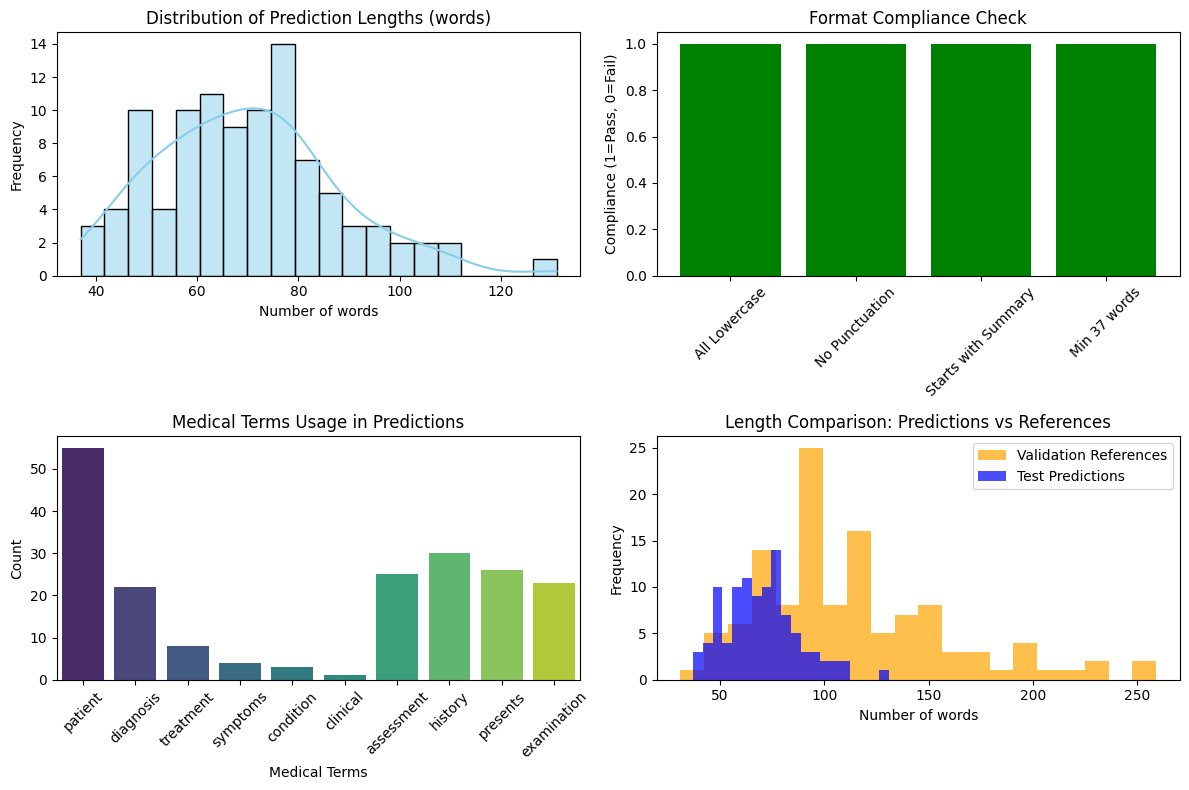


📊 DETAILED STATISTICS:
Total predictions: 100
Average length: 69.8 words
Median length: 68.5 words
Standard deviation: 17.5 words
Length range: 37 - 131 words

🏥 MEDICAL CONTENT ANALYSIS:
Patient: 55/100 (55.0%)
Diagnosis: 22/100 (22.0%)
Treatment: 8/100 (8.0%)
Symptoms: 4/100 (4.0%)
Condition: 3/100 (3.0%)
Clinical: 1/100 (1.0%)
Assessment: 25/100 (25.0%)
History: 30/100 (30.0%)
Presents: 26/100 (26.0%)
Examination: 23/100 (23.0%)

🔍 SAMPLE PREDICTIONS SHOWCASE:

Sample 1 (ID: ID_CUAOY):
Length: 72 words
Text: summary a 24 year old female complains of sharp pain in the right side of the nose that started 2 days ago which has been gradually worsening no past medical history on assessment tenderness on palpat...

Sample 2 (ID: ID_BZMKN):
Length: 49 words
Text: summary a 27 year old male with tracheostomy secondary to injuries following attempted suicide patient is irritable and uncooperative while settling patient in bed he violently turn and dislodge the t...

Sample 3 (ID: ID_SIPNK):

In [13]:
test_dataset = load_from_disk('outputs/test_dataset')
submission = pd.read_csv('outputs/submission.csv')

print("🎯 FINAL ANALYSIS & VISUALIZATIONS")
print("=" * 60)

# 1. Prediction length distribution
prediction_lengths = [len(pred.split()) for pred in submission['Clinician']]
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(prediction_lengths, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Prediction Lengths (words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# 2. Format compliance detailed check
all_lowercase = all(pred.islower() for pred in submission['Clinician'])
no_punctuation = all(not any(c in pred for c in '.,!?;:"()[]{}') for pred in submission['Clinician'])
starts_with_summary = all(pred.startswith('summary') for pred in submission['Clinician'])

plt.subplot(2, 2, 2)
compliance_data = [
    ('All Lowercase', all_lowercase),
    ('No Punctuation', no_punctuation), 
    ('Starts with Summary', starts_with_summary),
    ('Min 37 words', min(prediction_lengths) >= 37)
]
labels, values = zip(*compliance_data)
colors = ['green' if v else 'red' for v in values]
plt.bar(labels, [1 if v else 0 for v in values], color=colors)
plt.title('Format Compliance Check')
plt.ylabel('Compliance (1=Pass, 0=Fail)')
plt.xticks(rotation=45)

# 3. Medical term usage analysis
medical_terms = ['patient', 'diagnosis', 'treatment', 'symptoms', 'condition', 'clinical', 'assessment', 'history', 'presents', 'examination']
medical_term_counts = [
    sum(1 for pred in submission['Clinician'] if term in pred.lower())
    for term in medical_terms
]

plt.subplot(2, 2, 3)
sns.barplot(x=medical_terms, y=medical_term_counts, palette='viridis')
plt.title('Medical Terms Usage in Predictions')
plt.xlabel('Medical Terms')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 4. Length comparison with training data (if available)
plt.subplot(2, 2, 4)
val_dataset = load_from_disk('outputs/val_dataset')
if 'Clinician' in val_dataset.column_names:
    val_lengths = [len(example['Clinician'].split()) for example in val_dataset]
    
    plt.hist(val_lengths, bins=20, alpha=0.7, label='Validation References', color='orange')
    plt.hist(prediction_lengths, bins=20, alpha=0.7, label='Test Predictions', color='blue')
    plt.title('Length Comparison: Predictions vs References')
    plt.xlabel('Number of words')
    plt.ylabel('Frequency')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Validation reference\nlengths not available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Length Analysis')

plt.tight_layout()
plt.show()

# 5. Detailed statistics
print(f"\n📊 DETAILED STATISTICS:")
print(f"{'='*40}")
print(f"Total predictions: {len(submission)}")
print(f"Average length: {np.mean(prediction_lengths):.1f} words")
print(f"Median length: {np.median(prediction_lengths):.1f} words")
print(f"Standard deviation: {np.std(prediction_lengths):.1f} words")
print(f"Length range: {min(prediction_lengths)} - {max(prediction_lengths)} words")

print(f"\n🏥 MEDICAL CONTENT ANALYSIS:")
print(f"{'='*40}")
for term, count in zip(medical_terms, medical_term_counts):
    percentage = (count / len(submission)) * 100
    print(f"{term.capitalize()}: {count}/{len(submission)} ({percentage:.1f}%)")

# 6. Sample predictions showcase
print(f"\n🔍 SAMPLE PREDICTIONS SHOWCASE:")
print(f"{'='*60}")
sample_indices = [0, len(submission)//4, len(submission)//2, 3*len(submission)//4, len(submission)-1]
for i, idx in enumerate(sample_indices):
    print(f"\nSample {i+1} (ID: {submission.iloc[idx]['Master_Index']}):")
    print(f"Length: {len(submission.iloc[idx]['Clinician'].split())} words")
    print(f"Text: {submission.iloc[idx]['Clinician'][:200]}...")

print(f"\n🎉 FINAL SUBMISSION READY!")
print(f"{'='*60}")
print(f"📁 File: outputs/submission.csv")
print(f"📊 Format: {submission.shape[0]} rows × {submission.shape[1]} columns")
print(f"✅ All format requirements met!")
